<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/o_x_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kézzel írt jelek osztályozása

A következőkben, egy egyszerű példán keresztül, az "o" és "x" jelek felismerésén mutatjuk be a gépi tanulási módszerek adatelőkészítési és tanitási folyamatát. Felügyelt tanítási módszereket alkalmazunk, osztályozási céllal.

Egy kisebb mintát (80 "o" és 80 "x") használunk, melyeket egy A4-es lapra írtunk.

Két módszert, egy gépi tanulási (Scikit Learn) és egy mély tanulási (Keras) eljárást mutatunk be.  gépi tanulásnál az SVM-t (Support vector machine), a mély tanulásnál pedig a Konvolúciós neurális hálózatokat használjuk.

## SVM (Support Vector Machine)

### Input adatok előkészítése

Az A4-es lapra írt, táblázatosan elrendezett adatokat fel kell darabolnunk, hogy egy képen csak egy jel legyen, egy kis kép felbontást 32 x 32 pixelre csökkentjük. (1024 dimenziós térben fogunk dolgozni!)

In [26]:
# Néhány konstans a feldolgozáshoz
image_size = 32                 # a kis képek mérete (négyzetes), pixel
sample_start = 0                # ettől a sortól kell feldolgozni a mintákat
sample_rows = 16                # eddig a sorig kell feldolgozni a mintákat
sample_cols = 10                # ennyi minta van egy sorban
sample_num = sample_rows * sample_cols  # összes minta száma
size = 177                      # markerek szkennelt mérete, pixel
border = 10                     # vágási margó, pixel
margin = 6                      # bal oldali margó
labels = ["circle", "cross"]    # cimke nevek, 0-kör, 1-x)

A feldolgozás során a Scikit Learn könyvtár SVM osztályát használjuk. A következő blokk a szükséges Python modulokat tölti be.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage.morphology import erosion
from skimage.util import invert
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

Töltsük le és jelenítsük meg a kiinduló A4-es szkennelt lapot.

In [28]:
!wget -q -O o_x.png https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/o_x.png?raw=true

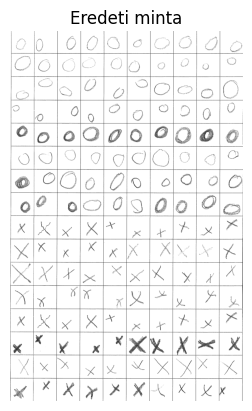

In [29]:
img = imread('o_x.png', as_gray=True)     # kép betöltése szürkeárnyalatosként
plt.axis("off")
plt.imshow(img, cmap='gray')
_ = plt.title("Eredeti minta")

Az előkészítés során az egyes kis mintákat kivágjuk a nagy képből, a vonalak esetleges szakadozását vastagítással megszüntetjük és kétszínű képpé alakítjuk (0/1 értékek a pixelekre).

In [30]:
# tömbök létrehozása a bemenő adatoknak és a címkéknek
scaling = True                                                # jel terjedelmére nagyítás igen/nem
X = np.zeros((sample_num, image_size, image_size, 1), dtype='float32')
y = np.zeros(sample_num, dtype='float32')
y[sample_num // 2:] = 1              # első fele "o"/0, második fele "x"/1
# az egyes jeleket tartalmazó képek létrehozása
k = 0
for i in range(sample_start, sample_start + sample_rows):     # minden sorra
    pixel_top = i * size + border                             # sor felső pixele
    pixel_bot = (i + 1) * size - border                       # sor alsó pixele
    for j in range(sample_cols):                                       # minden oszlopra
        pixel_left = margin + j * size + border               # oszlop bal széle pixel
        pixel_righ = (j + 1) * size - border                  # oszlop jobb széle pixel
        sub_img = erosion(erosion(img[pixel_top:pixel_bot,pixel_left:pixel_righ]))
        thresh = threshold_otsu(sub_img)                      # fekete-fehérré alakítás
        sub_img = (sub_img > thresh).astype('uint8')
        inv = invert(sub_img) - 254
        indx = np.nonzero(inv)
        sub_row0, sub_row1 = np.min(indx[0]), np.max(indx[0]+1) # jel befoglaló idoma
        sub_col0, sub_col1 = np.min(indx[1]), np.max(indx[1]+1)
        if scaling:
            # jel területének a kivétele és a felbontás lecsökkentése
            X[k] = np.expand_dims(resize(sub_img[sub_row0:sub_row1, sub_col0:sub_col1], (image_size, image_size)), -1)
        else:
            # felbontás lecsökkentése
            X[k] = np.expand_dims(resize(sub_img, (image_size, image_size)), -1)
        k += 1

Nézzük meg az egyes jelek képét és a hozzájuk tartozó címkéket!

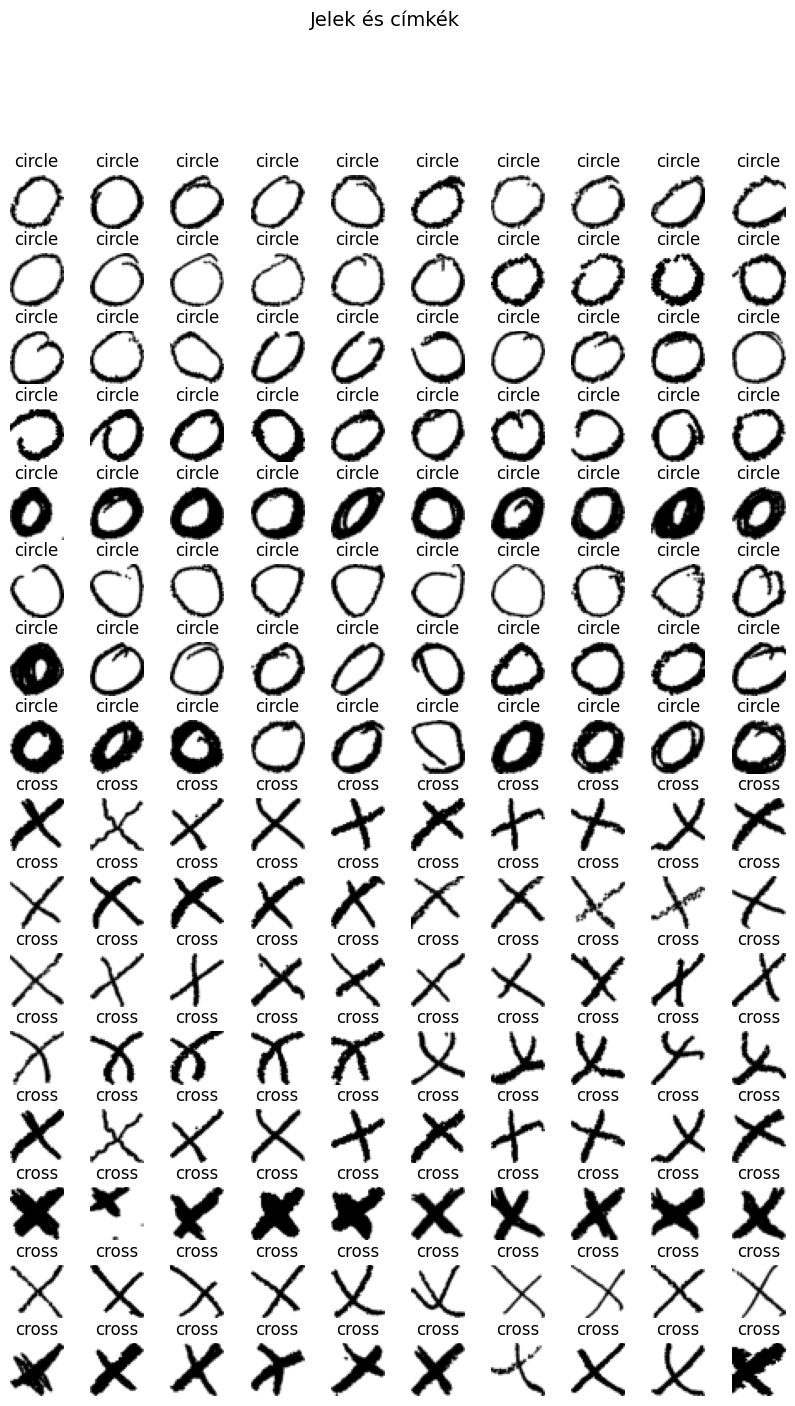

In [31]:
fig, ax = plt.subplots(sample_rows, sample_cols, figsize=(sample_cols, sample_rows))
fig.suptitle('Jelek és címkék', fontsize=14)
ax = ax.ravel()
for i in range(sample_rows * sample_cols):
    ax[i].imshow(X[i], cmap='gray')
    ax[i].set_title(labels[int(y[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

Bontsuk fel az adatokat tréning (70%) és teszt (30%) adatokra.
A SVM csak vektorokat tud input adatként kezelni, ezért a image_size x image_size méretű mátrixokkat vektorrá kell átalakítani.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
XX_train = np.zeros((X_train.shape[0], image_size * image_size), dtype='float32')
XX_test = np.zeros((X_test.shape[0], image_size * image_size), dtype='float32')
for i in range(X_train.shape[0]):
    XX_train[i] = X_train[i].reshape(image_size * image_size)
for i in range(X_test.shape[0]):
    XX_test[i] = X_test[i].reshape(image_size * image_size)

Létrehozzuk az SVM osztály példányát.

In [33]:
clf = svm.SVC(C=1000000000.0, gamma=1e-6, kernel="rbf")                 # hiper paraméterek beállítása!
clf.fit(XX_train, y_train)                                              # modell tanítása tréning adatokkal
y_test_pred = clf.predict(XX_test)                                      # teszt adatokra becslés a modellből
y_train_pred = clf.predict(XX_train)                                    # tréning adatokra becslés a modellből
print(f"Pontosság (teszt/tréning): {metrics.accuracy_score(y_test, y_test_pred):.1%} / {metrics.accuracy_score(y_train, y_train_pred):.1%}")

Pontosság (teszt/tréning): 100.0% / 100.0%


Hasonlítsuk össze a teszt adatok ismert címkéit a modellből becsült címkékkel!

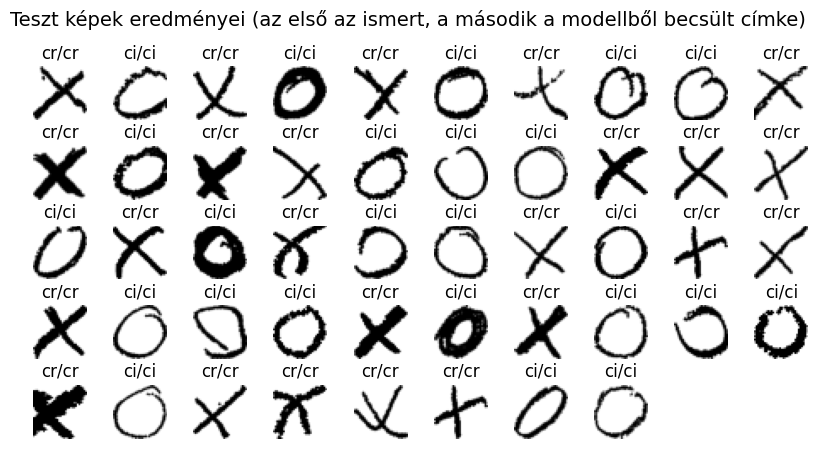

In [34]:
fig, ax = plt.subplots(X_test.shape[0]//sample_cols+1, sample_cols, figsize=(sample_cols, X_test.shape[0]//sample_cols+1))
fig.suptitle('Teszt képek eredményei (az első az ismert, a második a modellből becsült címke)', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots
for i in range(X_test.shape[0]):
    cmap = 'gray' if int(y_test[i]) == int(y_test_pred[i]) else 'Reds'
    ax[i].imshow(X_test[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(y_test[i])][:2]}/{labels[int(y_test_pred[i])][:2]}")
plt.subplots_adjust(wspace=0.5)

## Megoldás konvolúciós neurális hálózattal

### Adatok előkészítése

A konvolúciós neurális hálózatok esetén az előkészítés során a szűrkeárnyalatos képeket használuk fel.

In [35]:
scaling = True                                             # jel terjedelmére nagyítás igen/nem
k = 0
for i in range(sample_start, sample_start + sample_rows):  # minden sorra
    pixel_top = i * size + border
    pixel_bot = (i + 1) * size - border
    for j in range(10):                                    # minden oszlopra
        pixel_left = margin + j * size + border
        pixel_righ = (j + 1) * size - border
        sub_img = img[pixel_top:pixel_bot,pixel_left:pixel_righ]
        sub_img = invert(sub_img)                          # kép invertálása, háttér fekete (0)
        indx = np.nonzero(sub_img)
        sub_row0, sub_row1 = np.min(indx[0]), np.max(indx[0]+1)
        sub_col0, sub_col1 = np.min(indx[1]), np.max(indx[1]+1)
        if scaling:
            # jel terjedelem
            X[k] = np.expand_dims(resize(sub_img[sub_row0:sub_row1, sub_col0:sub_col1], (image_size, image_size)), -1)
        else:
            X[k] = np.expand_dims(resize(sub_img, (image_size, image_size)), -1)
        k += 1

Nézzük meg a kialakított képeket a címkékkel együtt!

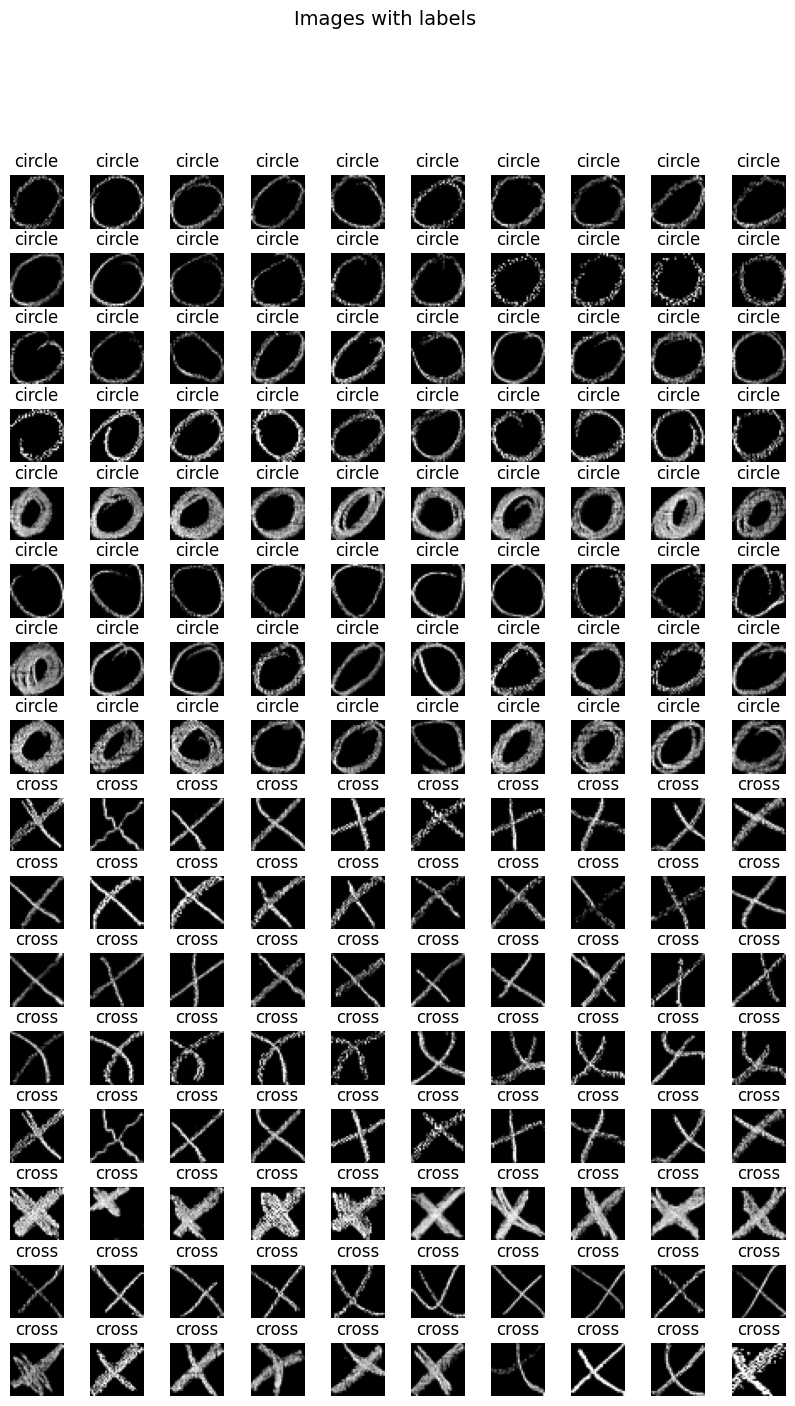

In [36]:
fig, ax = plt.subplots(sample_rows, sample_cols, figsize=(sample_cols, sample_rows))
fig.suptitle('Images with labels', fontsize=14)
ax = ax.ravel()
for i in range(sample_rows * sample_cols):
    ax[i].imshow(X[i], cmap='gray')
    ax[i].set_title(labels[int(y[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

### CNN modell felállítása és betanítása

A konvolúciós neurális hálózathoz a Keras könyvtárat használjuk.

In [37]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import to_categorical

Bontsuk fel az adatainkat tréning (70%) és teszt (30%) adatokra.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
y_train = to_categorical(y_train, 2)    # címkék szükséges átalakítása Kerashoz
y_test = to_categorical(y_test, 2)
filter_size = 3                         # 3 x 3 konvolúciós szűrőket használunk
filter_num = 4                          # scaling=False esetén 8

Hozzuk létre a modellünket a Kerasban. A modell rétegekből áll.

In [39]:
model = Sequential()
# konvolúciós szűrők
model.add(Conv2D(filter_num, (filter_size, filter_size), activation='relu', input_shape=(image_size, image_size, 1)))
model.add(MaxPooling2D((2, 2)))                 # kép méret felére csökkentése
# alternatív megoldás scaling=False esetre
#model.add(Conv2D(filter_num, (filter_size, filter_size), activation='relu', input_shape=(image_size, image_size, 1)))
#model.add(MaxPooling2D((2, 2)))                 # kép méret felére csökkentése
model.add(Flatten())                            # kép vektorrá alakítása
model.add(Dropout(0.3))                         # súlyok véletlenszerű kihagyása
model.add(Dense(2, activation='softmax'))       # kimeneti réteg
# compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 4)         40        
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 4)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 900)               0         
                                                                 
 dropout_1 (Dropout)         (None, 900)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1802      
                                                                 
Total params: 1842 (7.20 KB)
Trainable params: 1842 (7.20 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

A modellünkben ezernél több ismeretlen érték meghatározására van szükség.

In [40]:
epochs = 8              # iterációk száma scaling=False esetén növeljük 15-re
batch_size = 16         # egyidejűleg feldolgozott minták száma
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/8
7/7 [==============================] - 1s 28ms/step - loss: 0.2155 - accuracy: 0.7411 - val_loss: 0.1967 - val_accuracy: 0.9167
Epoch 2/8
7/7 [==============================] - 0s 9ms/step - loss: 0.1822 - accuracy: 0.8929 - val_loss: 0.1582 - val_accuracy: 1.0000
Epoch 3/8
7/7 [==============================] - 0s 7ms/step - loss: 0.1438 - accuracy: 0.9464 - val_loss: 0.1242 - val_accuracy: 1.0000
Epoch 4/8
7/7 [==============================] - 0s 9ms/step - loss: 0.1069 - accuracy: 0.9732 - val_loss: 0.0955 - val_accuracy: 1.0000
Epoch 5/8
7/7 [==============================] - 0s 9ms/step - loss: 0.0847 - accuracy: 0.9821 - val_loss: 0.0726 - val_accuracy: 1.0000
Epoch 6/8
7/7 [==============================] - 0s 10ms/step - loss: 0.0694 - accuracy: 0.9911 - val_loss: 0.0548 - val_accuracy: 1.0000
Epoch 7/8
7/7 [==============================] - 0s 9ms/step - loss: 0.0510 - accuracy: 0.9911 - val_loss: 0.0422 - val_accuracy: 1.0000
Epoch 8/8
7/7 [========================

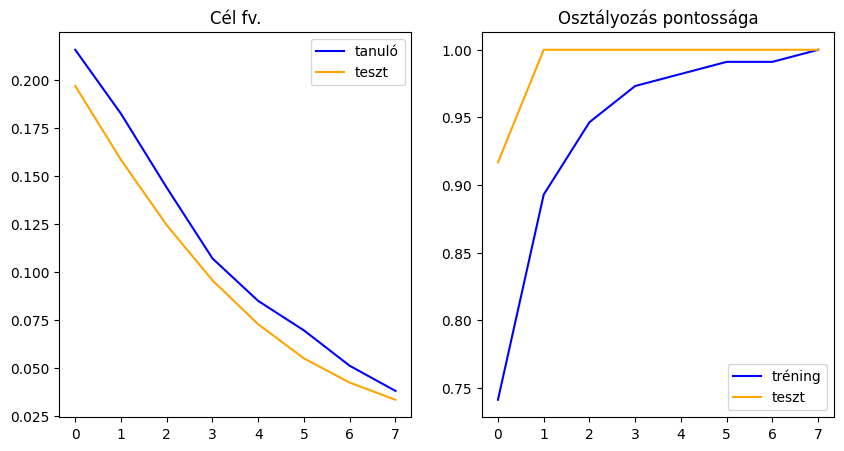

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Cél fv.')
ax[0].plot(history.history['loss'], color='blue', label='tanuló')
ax[0].plot(history.history['val_loss'], color='orange', label='teszt')
ax[0].legend()
# pontosság ábrázolása
ax[1].set_title('Osztályozás pontossága')
ax[1].plot(history.history['accuracy'], color='blue', label='tréning')
ax[1].plot(history.history['val_accuracy'], color='orange', label='teszt')
ax[1].legend(loc=4)

Vizsgáljuk meg a modell eredményét a teszt adatokra.

In [42]:
from keras.metrics import binary_accuracy
y_pred_test = model.predict(X_test)
print(f"Pontosság teszt adatokra: {np.sum(binary_accuracy(y_test, y_pred_test, threshold=0.5)) / y_pred_test.shape[0]:.1%}")

2/2 [==============================] - 0s 4ms/step
Pontosság teszt adatokra: 100.0%


Vizsgáljuk meg a teszt képekre kapott eredményeket. Az SVM-től eltérően itt százalékos értéket kapunk a becslés megbízhatóságára.

2/2 [==============================] - 0s 5ms/step


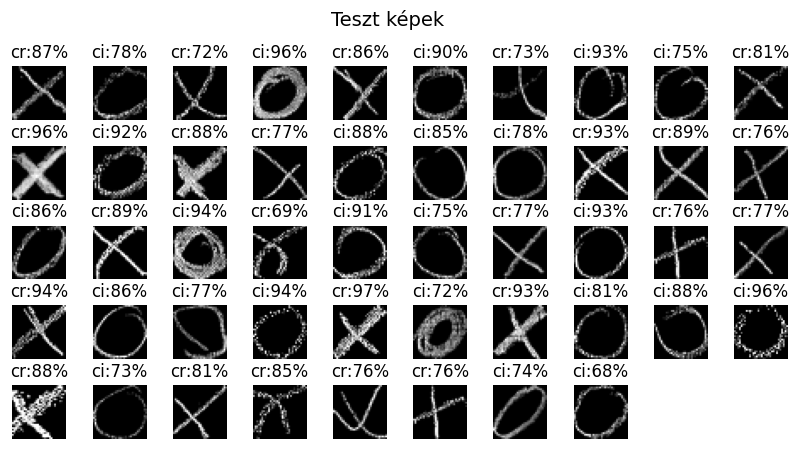

In [43]:
y_pred_test = model.predict(X_test)
pred_test_classes = np.argmax(y_pred_test, axis=1)
fig, ax = plt.subplots(X_test.shape[0]//sample_cols+1, sample_cols, figsize=(sample_cols, X_test.shape[0]//sample_cols+1))
fig.suptitle('Teszt képek', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(X_test.shape[0]):
    cls = pred_test_classes[i]     # 0/1
    val = y_pred_test[i, cls]
    cmap = 'gray' if y_test[i, cls] == 1 else 'Reds'
    ax[i].imshow(X_test[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(cls)][:2]}:{val:.0%}")
plt.subplots_adjust(wspace=0.5)

Végül nézzük meg a tanítás során kialakított konvolúciós szűrőket.

In [44]:
print("Konvolúciós szűrők")
for layer in model.layers:
    if layer.name.startswith('conv'):
        filters, biases = layer.get_weights()
        # szűrő súlyok kiírása
        for k in range(filter_size):
            for m in range(filters.shape[-1]):
                for l in range(filter_size):
                    print(f"{filters[k, l, 0, m]:5.2f}", end=" ")
                print(end="| ")
            print()
    print()


Konvolúciós szűrők
-0.35 -0.28 -0.19 | -0.30  0.06  0.12 |  0.10  0.07  0.35 |  0.19 -0.27 -0.26 | 
-0.20 -0.08  0.00 | -0.12  0.08 -0.27 |  0.14  0.11  0.16 | -0.18 -0.20 -0.18 | 
 0.13  0.36  0.19 | -0.22  0.40 -0.25 |  0.02 -0.12  0.34 | -0.12 -0.29  0.12 | 







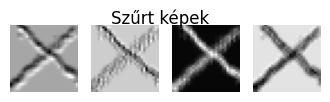

In [45]:
from scipy.signal import convolve2d
nf = filters.shape[-1]
fig, ax = plt.subplots(1, nf, figsize=(nf, 1))
fig.suptitle('Szűrt képek')
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots
kk = 0
for i in range(filters.shape[-1]):
    i1 = convolve2d(X_test[kk,:,:,0], filters[:,:,0,i], 'valid')
    ax[i].imshow(i1, cmap='gray')